In [27]:
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from prettytable import PrettyTable
from sklearn.decomposition import PCA
from sklearn.datasets import load_wine
from scipy.stats import multivariate_normal
from sklearn.metrics import silhouette_score

warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)

In [28]:
class EM:
    def __init__(self):
        self.k = 0
        self.num = 0
        self.attr = 0
        self.mu = None
        self.sigma = None
        self.pi = None

    def initialise(self, data, k):
        self.k = k
        self.data = data
        self.num, self.attr = data.shape
        self.gamma = np.ones((self.num, k)) / k # responsibilities
        self.mu = data[np.random.choice(self.num, k, replace=False)] # means
        self.sigma = [np.eye(self.attr) for _ in range(k)] # covariances
        self.pi = np.ones(k) / k # coefficients

    # expectation step
    def expectation(self):
        for i in range(self.num):
            for j in range(self.k):
                temp = multivariate_normal.pdf(self.data[i], self.mu[j], self.sigma[j])
                self.gamma[i][j] = self.pi[j]*temp
            self.gamma[i] /= np.sum(self.gamma[i])

    # maximization step
    def maximization(self):
        mu = np.zeros((self.k, self.attr))
        sigma = [np.zeros((self.attr, self.attr)) for _ in range(self.k)]
        pi = np.zeros(self.k)
        for j in range(self.k):
            factor = np.sum(self.gamma[:,j])
            for i in range(self.num):
                mu[j] += self.gamma[i][j]*self.data[i]
            mu[j] /= factor
            for i in range(self.num):
                sigma[j] += self.gamma[i][j]*np.outer(self.data[i]-mu[j], self.data[i]-mu[j])
            sigma[j] /= factor
            pi[j] = factor / self.num
        self.mu = mu
        self.sigma = sigma + 1e-6*np.eye(self.attr)
        self.pi = pi
        
    # log likelihood
    def log_likelihood(self):
        log_likelihood = 0
        for i in range(self.num):
            likelihood = 0
            for j in range(self.k):
                likelihood += self.pi[j]*multivariate_normal.pdf(self.data[i], self.mu[j], self.sigma[j])
            log_likelihood += np.log(likelihood)
        return log_likelihood

    def fit(self, data, k):
        self.initialise(data, k)
        idx, prev, curr = 0, 0, 0
        while True:
            idx += 1
            self.expectation()
            self.maximization()
            curr = self.log_likelihood()
            if abs(curr-prev) < 1e-3:
                # print(f'converged in {idx} iterations')
                break
            prev = curr
            
    def likelihood(self):
        likelihood = np.zeros(self.num)
        for i in range(self.num):
            for j in range(self.k):
                likelihood[i] += self.pi[j]*multivariate_normal.pdf(self.data[i], self.mu[j], self.sigma[j])
        return likelihood
    
    def parameters(self):
        return self.mu, self.sigma, self.pi
    
    def membership_values(self):
        return self.gamma
    
    def labels(self):
        return np.argmax(self.gamma, axis=1)
    
    def BIC_score(self):
        log_likelihood = self.log_likelihood()
        return -2*log_likelihood + self.k*np.log(self.num)
    
    def AIC_score(self):
        log_likelihood = self.log_likelihood()
        return -2*log_likelihood + 2*self.k

- Applied Standardization on the customer dataset.
- Applied the EM algorithm varying the number of Gaussian Mixture Models from 2 to 10.
- Noted the log-likelihood values and Silhouette score after convergence of the algorihtm. 

In [29]:
# customer dataset -- 2000 x 7
data = pd.read_csv('2/SMAI-Dataset-customer-dataset/data.csv')
data = data.drop(data.columns[0], axis=1)
columns = list(data)
for i in columns:
    if i=='Age' or i=='Income':
        mean = data[i].mean()
        std = data[i].std()
        data[i] = (data[i]-mean) / std
data = data.to_numpy()

t = PrettyTable(['Number of clusters', 'Log-likelihood', 'Silhouette score'])
for k in range(2, 11):
    gmm = EM()
    gmm.fit(data, k)
    labels = gmm.labels()
    log_likelihood = gmm.log_likelihood()
    score = silhouette_score(data, labels)
    t.add_row([k, log_likelihood, score])
print(t)

+--------------------+---------------------+------------------------+
| Number of clusters |    Log-likelihood   |    Silhouette score    |
+--------------------+---------------------+------------------------+
|         2          |  -309.3388789276491 | -0.0002816880605451195 |
|         3          | -1248.4484062602914 |   0.1754541588060382   |
|         4          |  2451.2911530486967 |  0.14245639029658996   |
|         5          |  12025.003740935736 |  0.10819189972121836   |
|         6          |  13427.73611674777  |  0.10700902696278254   |
|         7          |  15123.642949578476 |  0.07713718095293408   |
|         8          |  14373.440236090733 |  0.09244548511929293   |
|         9          |  19184.951723948474 |   0.1266510777554376   |
|         10         |   18603.7113653941  |  0.07161518652405892   |
+--------------------+---------------------+------------------------+


- Applied Standardization on the wine dataset.
- Applied the EM algorithm varying the number of Gaussian Mixture Models from 1 to 20.
- Stored the AIC and BIC scores and plotted them as we vary the number of models.

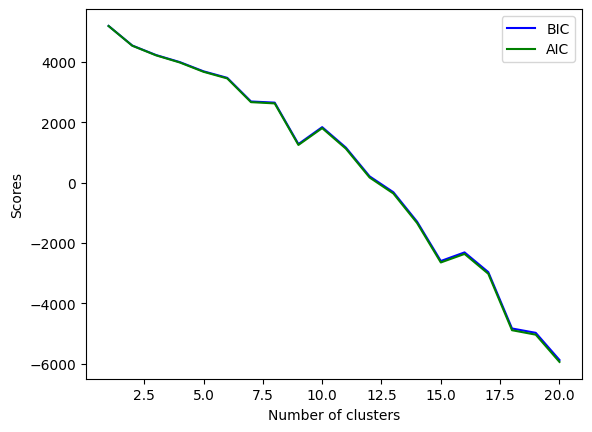

In [30]:
# wine dataset -- 178 x 13
dataset = load_wine()
data = pd.DataFrame(dataset.data)
columns = list(data)
for i in columns:
    mean = data[i].mean()
    std = data[i].std()
    data[i] = (data[i]-mean) / std
data = data.to_numpy()

idx = []
aic = []
bic = []
for k in range(20):
    idx.append(k+1)
    gmm = EM()
    gmm.fit(data, k+1)
    bic.append(gmm.BIC_score())
    aic.append(gmm.AIC_score())

plt.plot(idx, bic, label='BIC', color='blue')
plt.plot(idx, aic, label='AIC', color='green')
plt.ylabel('Scores')
plt.xlabel('Number of clusters')
plt.legend()
plt.show()

- Applied PCA on the wine dataset with 2 as the number of components.
- Applied KMeans and EM algorithm on the reduced dataset.
- Displayed the scatter plots using the labels derived from each of the algorithms.
- Also, calculated the Silhouette score for both the algorithms and displayed it.

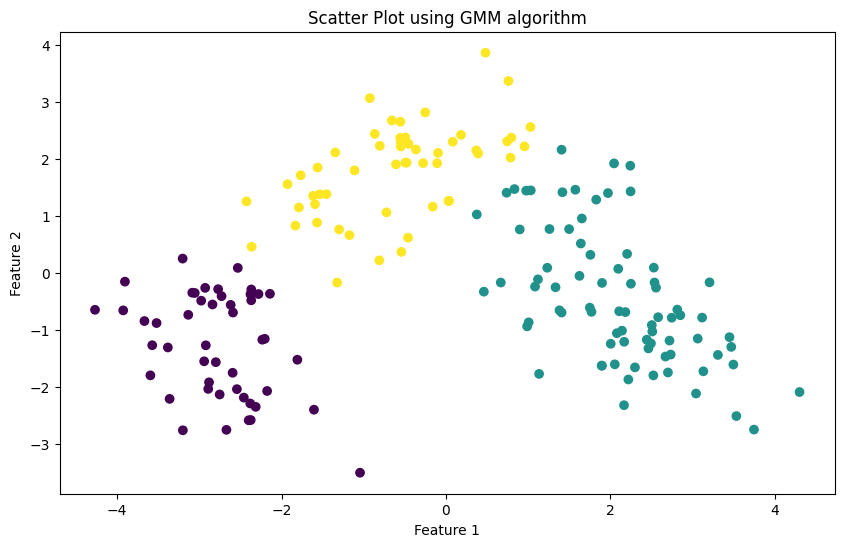

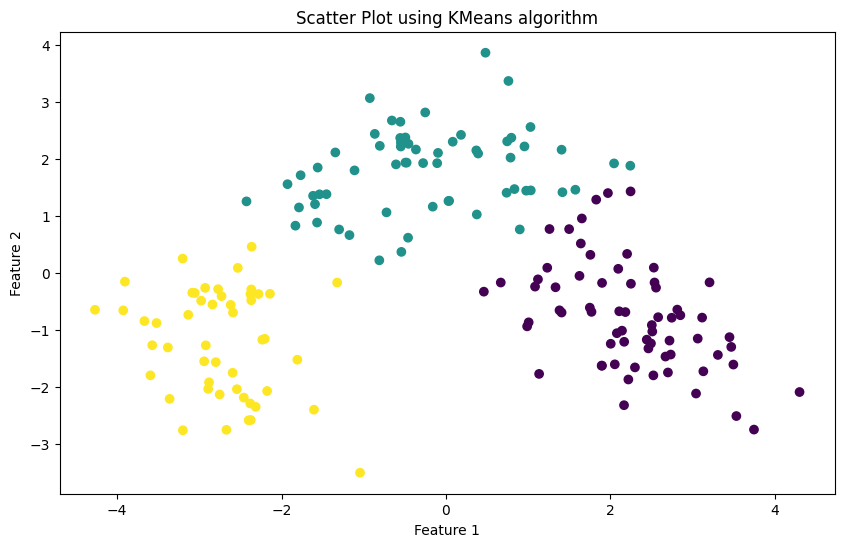

+-----------+--------------------+
| Algorithm |  Silhouette score  |
+-----------+--------------------+
|    GMM    | 0.5319722918135587 |
|   KMeans  | 0.5609305721582906 |
+-----------+--------------------+


In [31]:
# using PCA on wine dataset
pca = PCA(n_components=2)
Z = pca.fit_transform(data)

gmm = EM()
gmm.fit(Z, 3)
gmm_labels = gmm.labels()
gmm_score = silhouette_score(Z, gmm_labels)
plt.figure(figsize=(10, 6))
plt.scatter(Z[:,0], Z[:,1], c=gmm_labels, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot using GMM algorithm')
plt.show()

kmeans = KMeans(n_clusters=3, n_init='auto')
kmeans.fit(Z)
kmeans_labels = kmeans.predict(Z)
kmeans_score = silhouette_score(Z, kmeans_labels)
plt.figure(figsize=(10, 6))
plt.scatter(Z[:,0], Z[:,1], c=kmeans_labels, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot using KMeans algorithm')
plt.show()

t = PrettyTable(['Algorithm', 'Silhouette score'])
t.add_row(['GMM', gmm_score])
t.add_row(['KMeans', kmeans_score])
print(t)